# Make Summary Plots



## Python stuff

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import sys, os, copy
import importlib as imp
import gc
import pickle

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
import seaborn as sns

import regionmask
import experiment_settings
import file_methods, plots, data_processing

import matplotlib as mpl
import cartopy as ct
import cartopy.feature as cfeature

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
# plt.style.use("seaborn-v0_8-notebook")
# np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import warnings

warnings.filterwarnings("ignore")

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"tensorflow version = {tf.__version__}")
print(f"tensorflow-probability version = {tfp.__version__}")

python version = 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) 
[Clang 14.0.6 ]
numpy version = 1.24.4
xarray version = 2022.9.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
PARENT_EXP_NAME = "exp134"
EXP_SUFFIX = ""  # "_3thresholds"
EVAL_THRESHOLD = 3.0
RNG_SEED = 66
# -------------------------------------------------------
settings = experiment_settings.get_settings(PARENT_EXP_NAME)
settings["target_temp"] = EVAL_THRESHOLD
# -------------------------------------------------------

MODEL_DIRECTORY = "saved_models/"
PREDICTIONS_DIRECTORY = "saved_predictions/"
DATA_DIRECTORY = (
    "../../../2022/target_temp_detection/data/"  # point to where your data is sitting
)
OBS_DIRECTORY = "../data/"
GCM_DATA_DIRECTORY = "../data/"
DIAGNOSTICS_DIRECTORY = "model_diagnostics/"
FIGURE_DIRECTORY = "figures/"

## Error map

In [4]:
imp.reload(data_processing)

# get the slopes from the stored pickle dictionaries of metrics
settings_obs = settings.copy()
settings_obs["target_region"] = None
settings_obs["obs_training_only"] = True

da_obs, x_obs, global_mean_obs = data_processing.get_observations(
    OBS_DIRECTORY, settings_obs
)
mask = regionmask.defined_regions.ar6.land.mask(da_obs)

ar6_land = regionmask.defined_regions.ar6.land
IPCC_REGION_LIST = ar6_land.abbrevs
REMOVE_REG_LIST = ("GIC", "EAN", "WAN")
# REMOVE_REG_LIST = ()

# initialize the matrics
test_metrics_matrix = np.zeros((len(IPCC_REGION_LIST), 3)) * np.nan
map_test_error = np.zeros(mask.shape) * np.nan

# loop and load the data for each region
for ireg, ipcc_region in enumerate(IPCC_REGION_LIST):
    settings = experiment_settings.get_settings(PARENT_EXP_NAME)
    settings["target_temp"] = EVAL_THRESHOLD
    settings["rng_seed"] = RNG_SEED
    settings["exp_name"] = PARENT_EXP_NAME + "_" + ipcc_region
    settings["target_region"] = "ipcc_" + ipcc_region
    model_name = file_methods.get_model_name(settings)

    # get base model metrics
    try:
        df_metrics = pd.read_pickle(
            PREDICTIONS_DIRECTORY + model_name + "_metrics.pickle"
        )
    except:
        continue

    if ipcc_region in REMOVE_REG_LIST:
        test_metrics_matrix[ireg, :] = np.nan
    else:
        test_metrics_matrix[ireg, 0] = df_metrics["loss_test"][0]
        test_metrics_matrix[ireg, 1] = df_metrics["error_test"][0]
        test_metrics_matrix[ireg, 2] = df_metrics["d_valtest"][0]

    map_test_error = np.where(
        mask != ireg, map_test_error, test_metrics_matrix[ireg, 1]
    )

print(
    "\nPercent Complete = "
    + str(
        np.round(
            100.0
            * np.count_nonzero(~np.isnan(test_metrics_matrix[:, 0]))
            / (test_metrics_matrix.shape[0] - len(REMOVE_REG_LIST)),
            1,
        )
    )
    + "%\n"
)

observations: filling NaNs with zeros
np.shape(x_obs) = (54, 72, 144, 1)
np.shape(data_obs) = (54, 72, 144)

Percent Complete = 100.0%



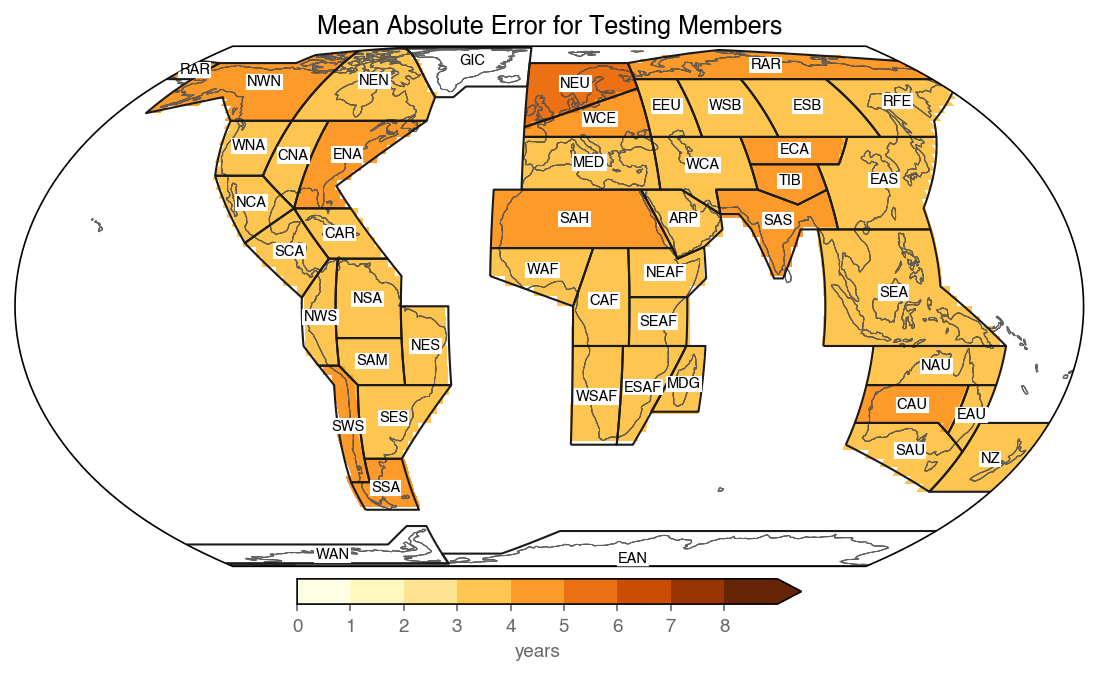

In [5]:
imp.reload(plots)

# plot the slopes
transform = ct.crs.PlateCarree()
projection = ct.crs.EqualEarth(central_longitude=0.0)
FS = 9
fig = plt.figure(figsize=(1.25 * 5.5 * 2, 1.25 * 3.75))

# -------------
a1 = fig.add_subplot(1, 1, 1, projection=projection)
cmap, cb_bounds = plt.cm.YlOrBr, [0.5, 8.5, 1.0]
clr_norm = plots.get_discrete_colornorm(cb_bounds, cmap)
c1 = a1.pcolormesh(
    da_obs.lon,
    da_obs.lat,
    map_test_error,
    cmap=cmap,
    transform=transform,
    norm=clr_norm,
)
a1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "110m", edgecolor="k", linewidth=0.5, facecolor="None"
    )
)
c1.set_clim(0, 8)
cb = fig.colorbar(
    c1,
    orientation="horizontal",
    shrink=0.25,
    extend="max",
    pad=0.02,
)
cb.set_label(
    label="years",
    fontsize=FS,
)
cb.ax.tick_params(labelsize=FS)
cb.ax.set_xticks(np.arange(0, 8 + 1))
plt.title("Mean Absolute Error for Testing Members")

text_kws = dict(color="k", fontsize=7, bbox=dict(pad=0.1, color="w"))
regionmask.defined_regions.ar6.land.plot(
    add_label=True,
    text_kws=text_kws,
    label="abbrev",
    label_multipolygon="all",
    add_ocean=False,
    ocean_kws=dict(color="lightblue", alpha=0.25),
    line_kws=dict(
        linewidth=1.0,
    ),
)

plt.tight_layout()
# plots.savefig(
#     FIGURE_DIRECTORY
#     + PARENT_EXP_NAME
#     + "_rng_seed"
#     + str(settings["rng_seed"])
#     + "_testing_error",
#     dpi=savefig_dpi,
# )
plt.show()
# plt.close()

## Example prediction

In [6]:
imp.reload(data_processing)

# get the slopes from the stored pickle dictionaries of metrics
settings_obs = settings.copy()
settings_obs["target_region"] = None
settings_obs["obs_training_only"] = True

da_obs, x_obs, global_mean_obs = data_processing.get_observations(
    OBS_DIRECTORY, settings_obs
)
mask = regionmask.defined_regions.ar6.land.mask(da_obs)

ar6_land = regionmask.defined_regions.ar6.land
IPCC_REGION_LIST = ar6_land.abbrevs
REMOVE_REG_LIST = ("GIC", "EAN", "WAN")
# REMOVE_REG_LIST = ()

# initialize the matrics
test_metrics_matrix = np.zeros((len(IPCC_REGION_LIST), 3)) * np.nan
map_test_error = np.zeros(mask.shape) * np.nan

# loop and load the data for each region
for ireg, ipcc_region in enumerate(IPCC_REGION_LIST):
    settings = experiment_settings.get_settings(PARENT_EXP_NAME)
    settings["target_temp"] = EVAL_THRESHOLD
    settings["rng_seed"] = RNG_SEED
    settings["exp_name"] = PARENT_EXP_NAME + "_" + ipcc_region
    settings["target_region"] = "ipcc_" + ipcc_region
    model_name = file_methods.get_model_name(settings)

    # get base model metrics
    try:
        df_metrics = pd.read_pickle(
            PREDICTIONS_DIRECTORY + model_name + "_metrics.pickle"
        )
    except:
        continue

    if ipcc_region != "CNA":
        test_metrics_matrix[ireg, :] = np.nan
    else:
        test_metrics_matrix[ireg, 0] = df_metrics["loss_test"][0]
        test_metrics_matrix[ireg, 1] = df_metrics["error_test"][0]
        test_metrics_matrix[ireg, 2] = df_metrics["d_valtest"][0]

    map_test_error = np.where(
        mask != ireg, map_test_error, test_metrics_matrix[ireg, 1]
    )

print(
    "\nPercent Complete = "
    + str(
        np.round(
            100.0
            * np.count_nonzero(~np.isnan(test_metrics_matrix[:, 0]))
            / (test_metrics_matrix.shape[0] - len(REMOVE_REG_LIST)),
            1,
        )
    )
    + "%\n"
)

observations: filling NaNs with zeros
np.shape(x_obs) = (54, 72, 144, 1)
np.shape(data_obs) = (54, 72, 144)

Percent Complete = 2.3%



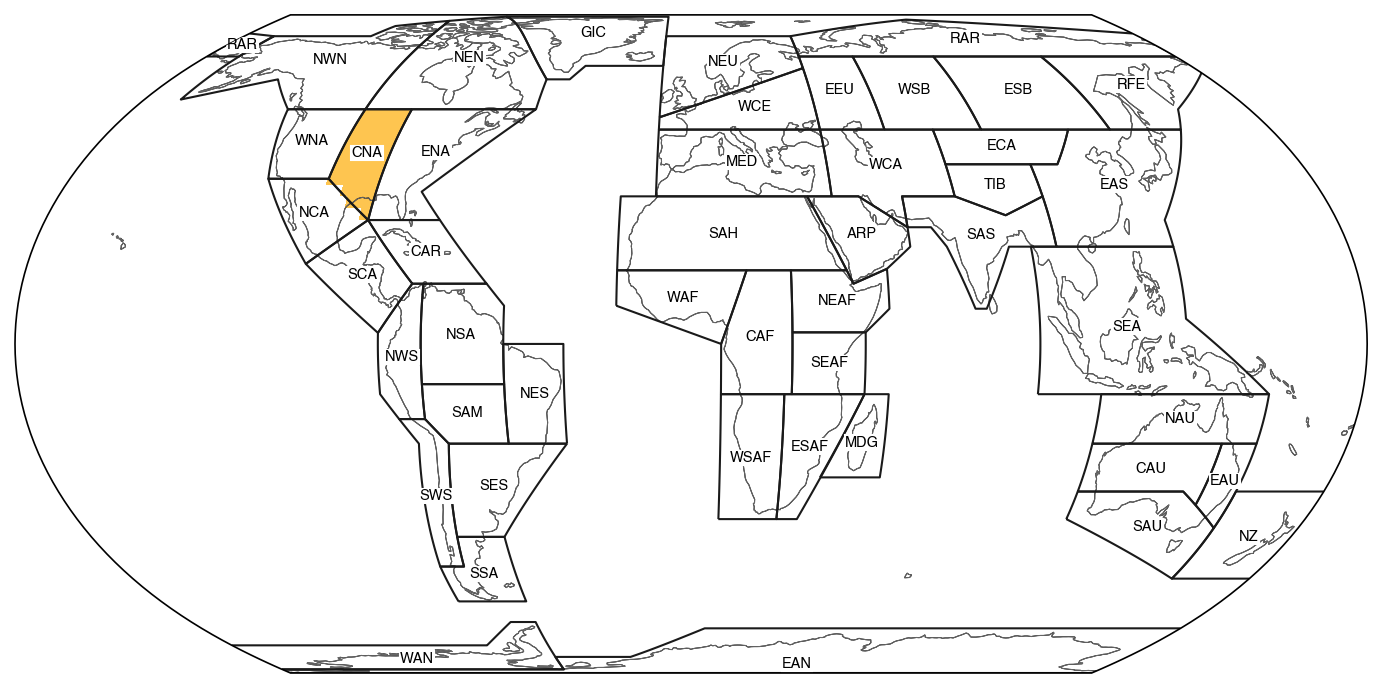

In [7]:
imp.reload(plots)

# plot the slopes
transform = ct.crs.PlateCarree()
projection = ct.crs.EqualEarth(central_longitude=0.0)
FS = 9
fig = plt.figure(figsize=(1.25 * 5.5 * 2, 1.25 * 3.75))

# -------------
a1 = fig.add_subplot(1, 1, 1, projection=projection)
cmap, cb_bounds = plt.cm.YlOrBr, [0.5, 8.5, 1.0]
clr_norm = plots.get_discrete_colornorm(cb_bounds, cmap)
c1 = a1.pcolormesh(
    da_obs.lon,
    da_obs.lat,
    map_test_error,
    cmap=cmap,
    transform=transform,
    norm=clr_norm,
)
a1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "110m", edgecolor="k", linewidth=0.5, facecolor="None"
    )
)
c1.set_clim(0, 8)
# cb = fig.colorbar(
#     c1,
#     orientation="horizontal",
#     shrink=0.25,
#     extend="max",
#     pad=0.02,
# )
# cb.set_label(
#     label="years",
#     fontsize=FS,
# )
# cb.ax.tick_params(labelsize=FS)
# cb.ax.set_xticks(np.arange(0, 8 + 1))

text_kws = dict(color="k", fontsize=7, bbox=dict(pad=0.1, color="w"))
regionmask.defined_regions.ar6.land.plot(
    add_label=True,
    text_kws=text_kws,
    label="abbrev",
    label_multipolygon="all",
    add_ocean=False,
    ocean_kws=dict(color="lightblue", alpha=0.25),
    line_kws=dict(
        linewidth=1.0,
    ),
)

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + "_example_prediction",
    dpi=savefig_dpi,
)
plt.show()
# plt.close()

In [8]:
raise ValueError()

ValueError: 

# Create Summary Plot

In [9]:
imp.reload(data_processing)

# --------------------------------------------------------
# GET OBSERVATIONS TRUE THRESHOLD YEARS
settings_obs["cumulative_history"] = False
settings_obs["obs_training_only"] = False
da_obs, __, __ = data_processing.get_observations(OBS_DIRECTORY, settings_obs)

obs_warming_year, obs_warming = data_processing.get_warming_year_single(
    settings_obs,
    da_obs.expand_dims(dim="gcm", axis=0),
    mask,
    IPCC_REGION_LIST,
    kind="quad_interp",
    show_plot=False,
)
obs_warming_year = np.ndarray.flatten(obs_warming_year)
# for item in list(zip(IPCC_REGION_LIST, obs_warming_year)): print(item)

observations: filling NaNs with zeros
np.shape(x_obs) = (174, 72, 144, 1)
np.shape(data_obs) = (174, 72, 144)


In [10]:
# files created in _transfer_shap.ipynb

# ------------------------------------------------------
# LOAD BASE MODEL PREDICTIONS
filename = (
    PREDICTIONS_DIRECTORY
    + PARENT_EXP_NAME
    + "_rng_seed"
    + str(settings["rng_seed"])
    + "_observations_"
    + str(settings["final_year_of_obs"])
    + "_predictions_base"
    + EXP_SUFFIX
    + ".pickle"
)
with open(filename, "rb") as f:
    (obs_base_dict,) = pickle.load(f)
obs_base = obs_base_dict[settings["target_temp"]]

# ------------------------------------------------------
# LOAD TRANSFER MODEL PREDICTIONS
filename = (
    PREDICTIONS_DIRECTORY
    + PARENT_EXP_NAME
    + "_rng_seed"
    + str(settings["rng_seed"])
    + "_observations_"
    + str(settings["final_year_of_obs"])
    + "_predictions_transfer"
    + EXP_SUFFIX
    + ".pickle"
)
with open(filename, "rb") as f:
    (obs_transfer_dict,) = pickle.load(f)
obs_transfer = obs_transfer_dict[settings["target_temp"]]

[18.45134544  3.71126747]
2041.4513454437256


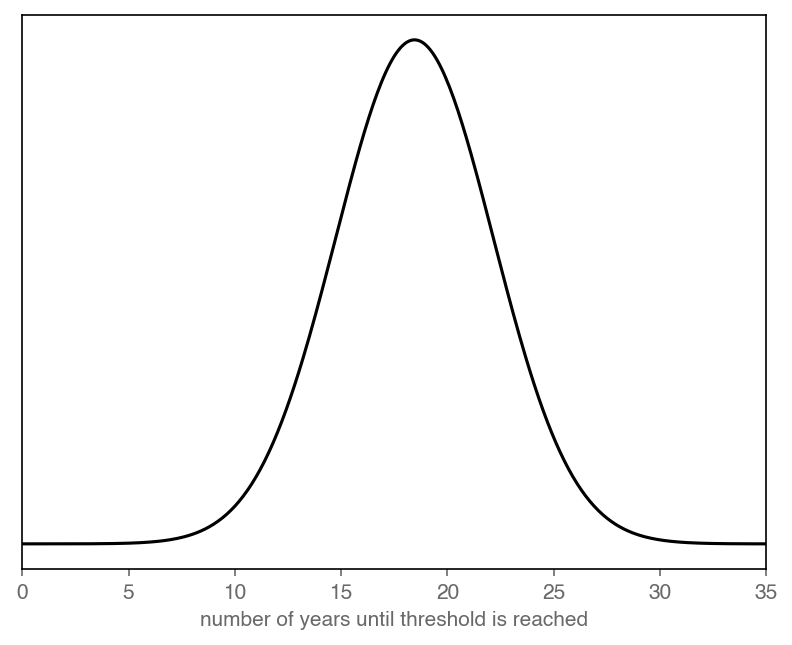

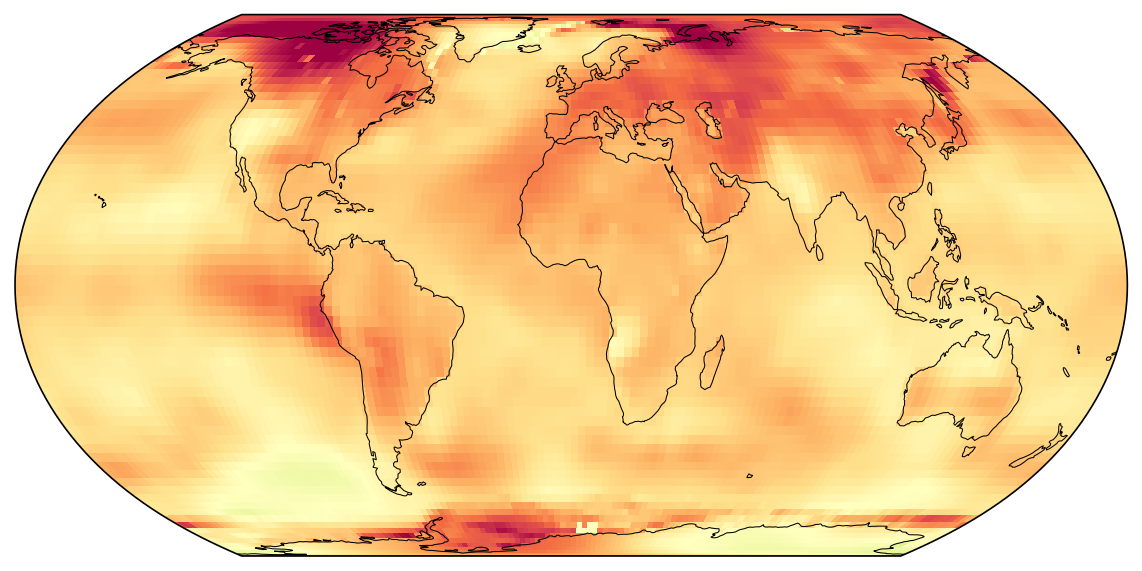

In [55]:
ireg = IPCC_REGION_LIST.index("CNA")
print(obs_transfer[ireg,:])
print(obs_transfer[ireg,0]+2023)

from scipy.stats import norm
x = np.arange(-20,60,.1)
y = norm.pdf(x, loc=obs_transfer[ireg,0], scale=obs_transfer[ireg,1])
plt.plot(x,y, "-k")
plt.xlim(0, 35)
plt.gca().yaxis.set_visible(False)
plt.xlabel("number of years until threshold is reached")

settings_obs["obs_training_only"] = True
__, x_obs, global_mean_obs = data_processing.get_observations(
    OBS_DIRECTORY, settings_obs, verbose=False
)
settings_obs["obs_training_only"] = False

imp.reload(plots)

# plot the slopes
transform = ct.crs.PlateCarree()
projection = ct.crs.EqualEarth(central_longitude=0.0)
FS = 9
fig = plt.figure(figsize=(1.25 * 5.5 * 2, 1.25 * 3.75))

# -------------
a1 = fig.add_subplot(1, 1, 1, projection=projection)
cmap = "Spectral_r"
# cmap, cb_bounds = plt.cm.YlOrBr, [0.5, 8.5, 1.0]
# clr_norm = plots.get_discrete_colornorm(cb_bounds, cmap)
c1 = a1.pcolormesh(
    da_obs.lon,
    da_obs.lat,
    # da_obs[-1,:,:],
    x_obs[-1, :, :, 0],
    cmap=cmap,
    transform=transform,
    # norm=clr_norm,
)
a1.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "110m", edgecolor="k", linewidth=0.5, facecolor="None"
    )
)
# cb = fig.colorbar(
#     c1,
#     orientation="horizontal",
#     shrink=0.25,
#     extend="max",
#     pad=0.02,
# )
c1.set_clim(-4, 4)
# plt.colorbar()
plt.show()

del x_obs, global_mean_obs

In [ ]:
# load the GCM data
imp.reload(data_processing)
imp.reload(file_methods)

# --------------------------------------------------------
# GET TRAINING CMIP6 STATS

training_gcm_filename = (
    PREDICTIONS_DIRECTORY
    + PARENT_EXP_NAME
    + "_training_target_years_"
    + str(settings["target_temp"])
    + ".pickle"
)
if os.path.isfile(training_gcm_filename):
    with open(training_gcm_filename, "rb") as f:
        (training_warming_year,) = pickle.load(f)
else:
    training_warming_year = np.zeros((len(IPCC_REGION_LIST), 7)) * np.nan
    for ireg, ipcc_region in enumerate(IPCC_REGION_LIST):
        settings = experiment_settings.get_settings(PARENT_EXP_NAME)
        settings["target_temp"] = EVAL_THRESHOLD
        settings["rng_seed"] = RNG_SEED
        settings["exp_name"] = PARENT_EXP_NAME + "_" + ipcc_region
        settings["target_region"] = "ipcc_" + ipcc_region
        model_name = file_methods.get_model_name(settings)

        tf.keras.utils.set_random_seed(settings["rng_seed"])
        (
            __,
            __,
            __,
            __,
            __,
            __,
            __,
            __,
            __,
            __,
            __,
            __,
            target_years_region,
            __,
            __,
        ) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)

        # compute range of target years across climate models
        training_warming_year[
            ireg, : len(target_years_region[: training_warming_year.shape[1]])
        ] = target_years_region[: training_warming_year.shape[1]]

        # save the results for next time
        with open(training_gcm_filename, "wb") as f:
            pickle.dump(
                [
                    training_warming_year,
                ],
                f,
            )

print(f"{training_warming_year.shape = }\n")

# --------------------------------------------------------
# GET SINGLE MEMBER CMIP6 STATS
settings_gcm = settings.copy()
settings_gcm["target_region"] = None
settings_gcm["anomaly_yr_bounds"] = settings_gcm["baseline_yr_bounds"]
data_all = data_processing.get_one_model_one_vote_data(GCM_DATA_DIRECTORY, settings_gcm)
gcm_filename = (
    PREDICTIONS_DIRECTORY
    + PARENT_EXP_NAME
    + "_gcm_onevote_warming_years_"
    + str(settings["target_temp"])
    + ".pickle"
)

print(f"{data_all.shape = }")

if os.path.isfile(gcm_filename):
    with open(gcm_filename, "rb") as f:
        (
            gcm_warming_year_rol,
            gcm_warming_year_cubic,
        ) = pickle.load(f)
else:
    gcm_warming_year_rol, __ = data_processing.get_warming_year_single(
        settings_gcm,
        data_all,
        mask,
        IPCC_REGION_LIST,
        kind="rolling",
        loops=1,
        show_plot=False,
    )

    gcm_warming_year_cubic, __ = data_processing.get_warming_year_single(
        settings_gcm,
        data_all,
        mask,
        IPCC_REGION_LIST,
        kind="quad_interp",
        loops=1,
        show_plot=False,
    )

    with open(gcm_filename, "wb") as f:
        pickle.dump([gcm_warming_year_rol, gcm_warming_year_cubic], f)

## Summary plot

In [ ]:
# ------------------------------------------------------
# GET REGIONS FOR ORGANIZING THE PLOT
REGION_CONTINENT_DICT = {}

continent = "North America"
for reg in IPCC_REGION_LIST:
    if reg == "NWS":
        continent = "South America"
    elif reg == "NEU":
        continent = "Europe"
    elif reg == "SAH":
        continent = "Africa"
    elif reg == "RAR":
        continent = "Asia"
    elif reg == "SEA":
        continent = "Maritime"

    REGION_CONTINENT_DICT[reg] = continent

SUBPLOT_DICT = {
    "North America": 1,
    "South America": 2,
    "Europe": 3,
    "Africa": 4,
    "Asia": 5,
    "Maritime": 6,
}

# ------------------------------------------------------
# PLOT REGIONS MAP
text_kws = dict(color="k", fontsize=7, bbox=dict(pad=0.2, color="w"))
regionmask.defined_regions.ar6.land.plot(
    text_kws=text_kws,
    label="abbrev",
    label_multipolygon="all",
    add_ocean=True,
    ocean_kws=dict(color="lightblue", alpha=0.25),
    line_kws=dict(
        linewidth=1.0,
    ),
)
plt.ylim(-60, 90)
plots.savefig(
    FIGURE_DIRECTORY + "regions_map",
    dpi=savefig_dpi,
)
plt.close()

In [ ]:
from scipy.stats import norm

# ------------------------------------------------------
# MAKE THE SUMMARY PLOT

LW = 5

mean_list = []

for kind in ("quad_interp",):
    if kind == "rolling":
        gcm_warming_year = gcm_warming_year_rol
    elif kind == "quad_interp":
        gcm_warming_year = gcm_warming_year_cubic
    else:
        raise NotImplementedError()

    plt.figure(figsize=(15, 5))

    last_region = "North America"
    for ireg, ipcc_region in enumerate(IPCC_REGION_LIST):
        # set x-location for plotting
        x_loc = ireg + (SUBPLOT_DICT[REGION_CONTINENT_DICT[ipcc_region]] - 1)
        if ireg == 0:
            x_ticks = [
                0,
            ]
        else:
            x_ticks = np.append(x_ticks, x_loc)

        if ipcc_region in REMOVE_REG_LIST:
            continue

        # plot training CMIP6 spread
        mid_val = -0.2
        (ln0,) = plt.plot(
            np.ones(training_warming_year.shape[1]) * (x_loc + mid_val),
            np.sort(training_warming_year[ireg, :]),
            ">",
            linewidth=LW,
            alpha=0.5,
            markersize=5,
            color="teal",
        )
        ln0.set_solid_capstyle("round")
        clr = ln0.get_color()

        # plot ALL GCM CMIP6 spread
        mid_val = -0.2
        (ln1,) = plt.plot(
            np.ones(gcm_warming_year.shape[0] * gcm_warming_year.shape[1])
            * (x_loc + mid_val),
            np.sort(gcm_warming_year[:, :, ireg], axis=None),
            "-",
            linewidth=LW,
            alpha=0.2,
            # color=clr,
            color="gray",
        )
        ln1.set_solid_capstyle("round")
        (ln1,) = plt.plot(
            [x_loc + mid_val - 0.11, x_loc + mid_val + 0.11],
            np.ones(2) * np.mean(gcm_warming_year[:, 0, ireg], axis=None),
            linewidth=2,
            alpha=0.2,
            # color=clr,
            color="gray",
        )

        # plot transfer learned observations gaussian
        vals = np.arange(-100, 100, 1)
        rvs = norm(obs_transfer[ireg, 0], obs_transfer[ireg, 1])
        mean_list.append(rvs.mean()+settings["final_year_of_obs"])
        xvals, yvals_tr = vals + settings["final_year_of_obs"], 5 * rvs.pdf(vals)
        i = np.where(yvals_tr > 0.0001)
        # plt.plot(yvals_tr[i] + ireg, xvals[i], "-", markersize=2, linewidth=1.75, alpha=0.85, color=clr)
        plt.plot(
            yvals_tr[i] + x_loc,
            xvals[i],
            "-",
            markersize=2,
            linewidth=1.75,
            alpha=0.85,
            color="darkorange",
        )

        # plot raw observations prediction gaussian
        vals = np.arange(-100, 100, 1)
        rvs = norm(obs_base[ireg, 0], obs_base[ireg, 1])
        xvals, yvals = vals + settings["final_year_of_obs"], 5 * rvs.pdf(vals)
        i = np.where(yvals > 0.0001)
        # plt.plot(yvals[i] + ireg, xvals[i], "--", markersize=2, linewidth=1.75, alpha=0.85, color=clr)
        plt.plot(
            yvals[i] + x_loc,
            xvals[i],
            "--",
            markersize=2,
            linewidth=1.0,
            alpha=0.85,
            color="teal",
        )

        # plot the actual warming to date
        k = np.argmin(np.abs((xvals - obs_warming_year[ireg])))
        plot_val = yvals_tr[k] + x_loc
        plt.plot(plot_val, obs_warming_year[ireg], "o", markersize=5, color="k")

    # make legend
    plt.plot(
        yvals[i] - 100,
        xvals[i],
        "--",
        color="teal",
        linewidth=1.75,
        alpha=0.85,
        label="Base-CNN Initialized with "
        + str(settings["final_year_of_obs"])
        + " Observations",
    )
    plt.plot(
        yvals[i] - 100,
        xvals[i],
        "-",
        color="darkorange",
        linewidth=1.75,
        alpha=0.85,
        label="Transfer-CNN Initialized with "
        + str(settings["final_year_of_obs"])
        + " Observations",
    )
    plt.plot(
        ireg - 100,
        obs_warming_year[ireg],
        "o",
        color="k",
        label="Estimated Observed Exceedance Year",
    )
    (ln0,) = plt.plot(
        np.ones(training_warming_year.shape[1]) * -100,
        np.sort(training_warming_year[ireg, :]),
        ">",
        linewidth=6,
        alpha=0.5,
        markersize=6,
        color="teal",
        label="7 Training Climate Model Ensembles",
    )
    # ln0.set_solid_capstyle('round')
    (ln1,) = plt.plot(
        np.ones(training_warming_year.shape[1]) * -100,
        np.sort(training_warming_year[ireg, :]),
        "-",
        linewidth=6,
        alpha=0.2,
        color="gray",
        label="CMIP6 Spread",
    )
    ln1.set_solid_capstyle("round")
    if settings["target_temp"] == 1.5:
        plt.legend(fontsize=8, frameon=True)

    ix = [
        IPCC_REGION_LIST.index(x) for x in IPCC_REGION_LIST if x not in REMOVE_REG_LIST
    ]
    plt.xticks(x_ticks[ix], np.asarray(IPCC_REGION_LIST)[ix], fontsize=7)
    plt.xlim(x_ticks[ix][0] - 1, len(ix) + 6)

    plt.ylim(1975, 2102)
    plt.ylabel("year threshold is reached")

    plt.title(str(settings["target_temp"]) + "C Temperature Threshold")
    plt.tight_layout()

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    for x in (9, 17, 22, 31, 42):
        plt.axvline(x=x, color="k", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.text(4, 1980, "NORTH AMERICA", ha="center")
    plt.text(13, 1980, "SOUTH AMERICA", ha="center")
    plt.text(19.5, 1980, "EUROPE", ha="center")
    plt.text(26.5, 1980, "AFRICA", ha="center")
    plt.text(36.5, 1980, "ASIA", ha="center")
    plt.text(45.5, 1980, "MARITIME", ha="center")

    # plt.xlim(1, len(IPCC_REGION_LIST) + 5 - 3)

    plots.savefig(
        FIGURE_DIRECTORY
        + PARENT_EXP_NAME
        + "_rng_seed"
        + str(settings["rng_seed"])
        + "_summary_figure_"
        + kind
        + EXP_SUFFIX
        + "_"
        + str(settings["target_temp"]),
        dpi=savefig_dpi,
    )
    plt.show()

In [ ]:
mean_list = np.asarray(mean_list)
i = np.where(mean_list<2060)[0]
total = np.where(mean_list<2100)[0]
print(np.round(100*len(i)/len(total)))
print(len(i), len(total))